In [4]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import time


In [6]:
#
## Parameters of the model
#
d0=16.
D = 373000*d0         # SA diffusion constant [nm^2/s]
lam = 7.5          # Ligand-receptor interaction range [nm] 

k0=1.0      # scale factor for the binding and unbinding reactions between HA and SA
k_on = 1000*k0*0.56*np.pi*np.power(lam,2)   # Binding rate of HA-SA bridges [s^-1]
k_off = 1000*k0*9.0          # Unbinding rate of HA-SA bridges [s^-1]
k01=4.0
k_d = 2000*np.pi*np.power(lam,2)*k01     # Destruction rate of SA by NA [s^-1]

R = 240.0             # Radius of the disk [nm]
A = np.pi * np.power(R,2)
A_ref=np.pi * np.power(60.,2)

R_max = 100.0*R       # Maximum radial distance for the simulation
c_HA_0 = 48./A_ref       # Uniform concentration of HA in the disk [nm^-2]
c_NA_0 = 13./A_ref       # Uniform concentration of NA in the disk [nm^-2]
c_SA_0 = 0.03        # Initial uniform concentration of SA [nm^-2]

t_fin=100.0

print('c_HA_0=',c_HA_0,'c_NA_0=',c_NA_0)


c_HA_0= 0.004244131815783876 c_NA_0= 0.0011494523667747998


In [ ]:
# dynamic solution

In [10]:

# Spatial grid
dr = 1.
r = np.arange(0, R_max + dr, dr)
N = len(r)

# Initial concentrations
c_SA = np.ones_like(r) * c_SA_0  # Initial SA concentration
c_B = np.zeros_like(r)           # Initial bridge concentration

# Define indices for the disk region
inside_disk = (r <= R)
outside_disk = ~inside_disk

# Time evolution function
#dt_check=1.
#last_print_t = -dt_check
starting_time=time.time()

def reaction_diffusion_2D(t, y, c_HA_0, c_NA_0):    
#    global last_print_t
#    if t - last_print_t >= dt_check:  # Print every 1 PDE time unit
#        print(f"Solving at t = {t:.2f}", "run time = ", time.time()-starting_time)
#        last_print_t = t  # Update last printed time
    c_rd_SA = y[:N]
    c_rd_B = y[N:]
    dSA_dt = np.zeros_like(c_rd_SA)
    dB_dt = np.zeros_like(c_rd_B)

    # Diffusion term for SA
    dSA_dt[1:-1] = D * (c_rd_SA[2:] - 2 * c_rd_SA[1:-1] + c_rd_SA[:-2]) / dr**2
    dSA_dt[1:-1] += D * (c_rd_SA[2:] - c_rd_SA[:-2]) / (2 * dr * r[1:-1])

    # Boundary conditions
    dSA_dt[0] = dSA_dt[1]  # Neumann BC at r=0
    dSA_dt[-1] = 0         # Dirichlet BC at r=R_max

    # Reaction inside the disk
    dSA_dt[inside_disk] -= k_on * (c_HA_0 - c_rd_B[inside_disk]) * c_rd_SA[inside_disk]
    dSA_dt[inside_disk] += k_off * c_rd_B[inside_disk]
    dSA_dt[inside_disk] -= k_d * c_NA_0 * c_rd_SA[inside_disk]

    dB_dt[inside_disk] += k_on * (c_HA_0 - c_rd_B[inside_disk]) * c_rd_SA[inside_disk]
    dB_dt[inside_disk] -= k_off * c_rd_B[inside_disk]

    return np.concatenate([dSA_dt, dB_dt])

# Initial state 
y0 = np.concatenate([c_SA, c_B])

# Time grid 
t_eval = np.linspace(0, t_fin, 1000)  # From t=0 to t=10, 100 points

# Solve the system 
solution = solve_ivp(
    reaction_diffusion_2D,
    [0, t_fin],
    y0,
    t_eval=t_eval,
    method='RK45',
    args=(c_HA_0, c_NA_0)
)

# Extract SA, B, and calculate total bridges over time
c_SA_t = solution.y[:N, :]
c_B_t = solution.y[N:, :]
N_B_t = 2 * np.pi * np.trapz(c_B_t[inside_disk, :] * r[inside_disk, None], r[inside_disk], axis=0)


file_t=f"time_D{D}_R{R}_kd{k01}.npy"
file_r=f"r_D{D}_R{R}_kd{k01}.npy"
file_c_SA=f"c_SA_D{D}_R{R}_kd{k01}.npy"
file_c_B=f"c_B_D{D}_R{R}_kd{k01}.npy"
file_N_B=f"N_B_D{D}_R{R}_kd{k01}.npy"


np.save(file_t,solution.t)
np.save(file_r,r)
np.save(file_c_SA,c_SA_t)
np.save(file_c_B,c_B_t)
np.save(file_N_B,N_B_t)


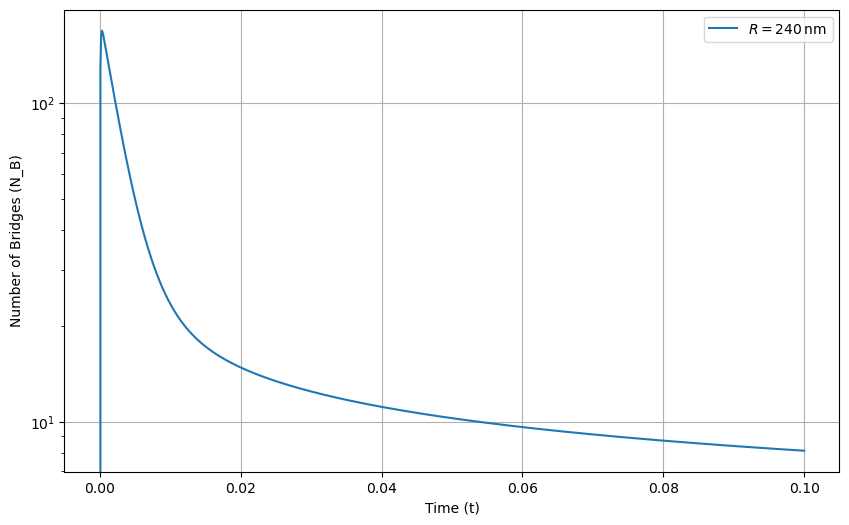

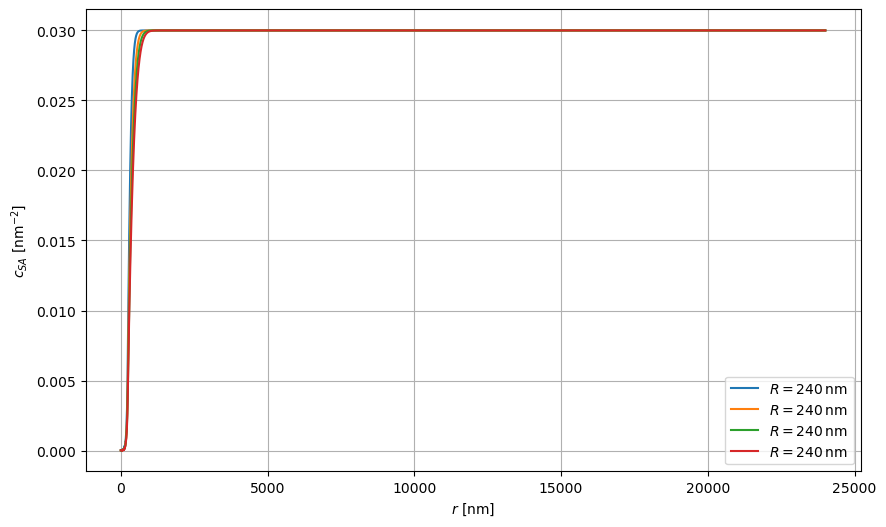

In [14]:

# Plot: number of bridges 
plt.figure(figsize=(10, 6))
plt.plot(solution.t, N_B_t, label=r'$R=240\,$nm')
plt.xlabel('Time (t)')
plt.ylabel('Number of Bridges (N_B)')
plt.legend()
#plt.title('Time Evolution of HA-SA Bridges in 2D with Cylindrical Symmetry')
plt.yscale('log')
plt.grid()
plt.show()

# Plot: SA concentration
plt.figure(figsize=(10, 6))
plt.plot(r, c_SA_t[:,250], label=r'$R=240\,$nm')
plt.plot(r, c_SA_t[:,500], label=r'$R=240\,$nm')
plt.plot(r, c_SA_t[:,750], label=r'$R=240\,$nm')
plt.plot(r, c_SA_t[:,999], label=r'$R=240\,$nm')
plt.xlabel(r'$r$ [nm]')
plt.ylabel(r'$c_{\it SA}$ [nm$^{-2}$]')
plt.legend()
plt.grid()
plt.show()


In [16]:
file_t=f"time_D{D}_R{R}_kd{k01}.npy"
file_r=f"r_D{D}_R{R}_kd{k01}.npy"
file_c_SA=f"c_SA_D{D}_R{R}_kd{k01}.npy"
file_c_B=f"c_B_D{D}_R{R}_kd{k01}.npy"
file_N_B=f"N_B_D{D}_R{R}_kd{k01}.npy"


t=np.load(file_t)
r=np.load(file_r)
c_SA_t=np.load(file_c_SA)
c_B_t=np.load(file_c_B)
N_B_t=np.load(file_N_B)


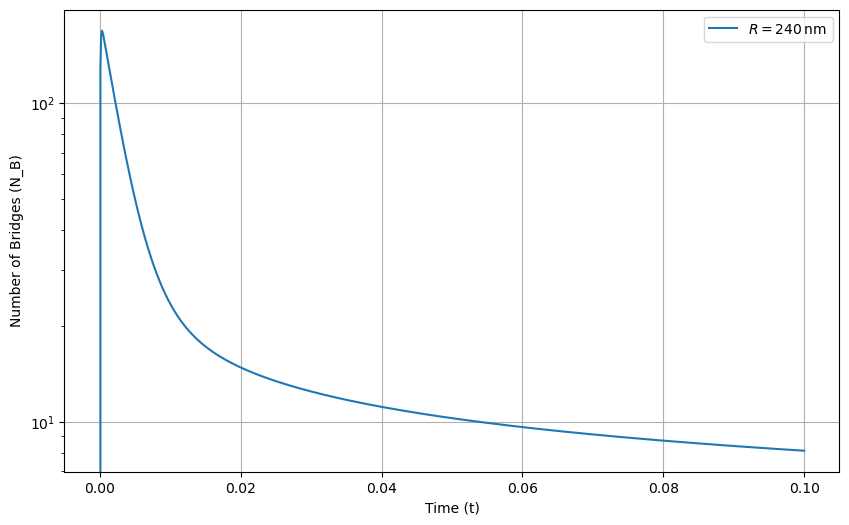

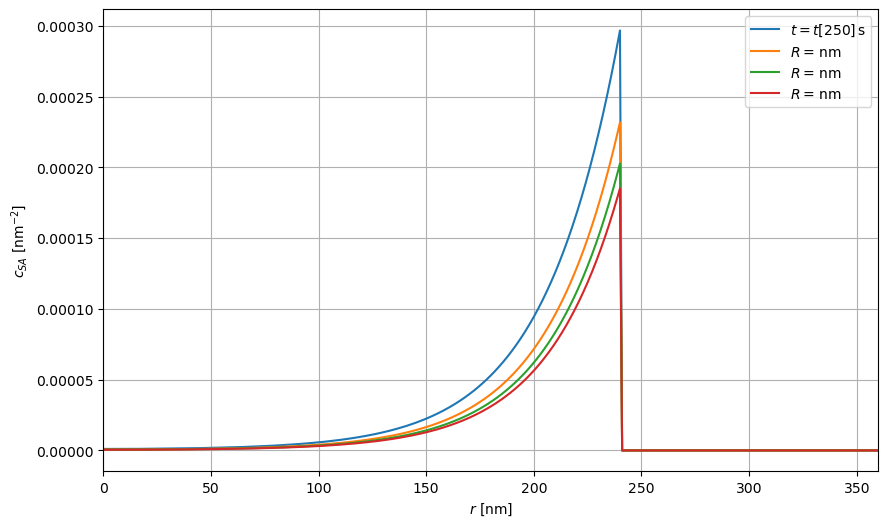

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(t, N_B_t, label=r'$R=240\,$nm')
plt.xlabel('Time (t)')
plt.ylabel('Number of Bridges (N_B)')
plt.legend()
#plt.title('Time Evolution of HA-SA Bridges in 2D with Cylindrical Symmetry')
plt.yscale('log')
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(r, c_B_t[:,250], label=r'$t={t[250]}\,$s')
plt.plot(r, c_B_t[:,500], label=r'$R=\,$nm')
plt.plot(r, c_B_t[:,750], label=r'$R=\,$nm')
plt.plot(r, c_B_t[:,999], label=r'$R=\,$nm')
plt.xlabel(r'$r$ [nm]')
plt.xlim(0,1.5*R)
plt.ylabel(r'$c_{\it SA}$ [nm$^{-2}$]')
plt.legend()
plt.grid()
plt.show()
